In [1]:
from core import *
from utils import *
from diagnostics import *
from fields import *
from constants import *
from distributions import *

from scipy import constants as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

import cProfile

def plot_traj(history):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = history[i, :, 0]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def plot_gca(gca):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = gca[i, :, :]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def to_percent(observed, actual):
    return abs((observed - actual) / actual) * 100

Load IGRF coefficients ...


In [2]:
e_field = zero_field()
b_field = t89(1)
solve   = solver(relativistic_boris(e_field, b_field))

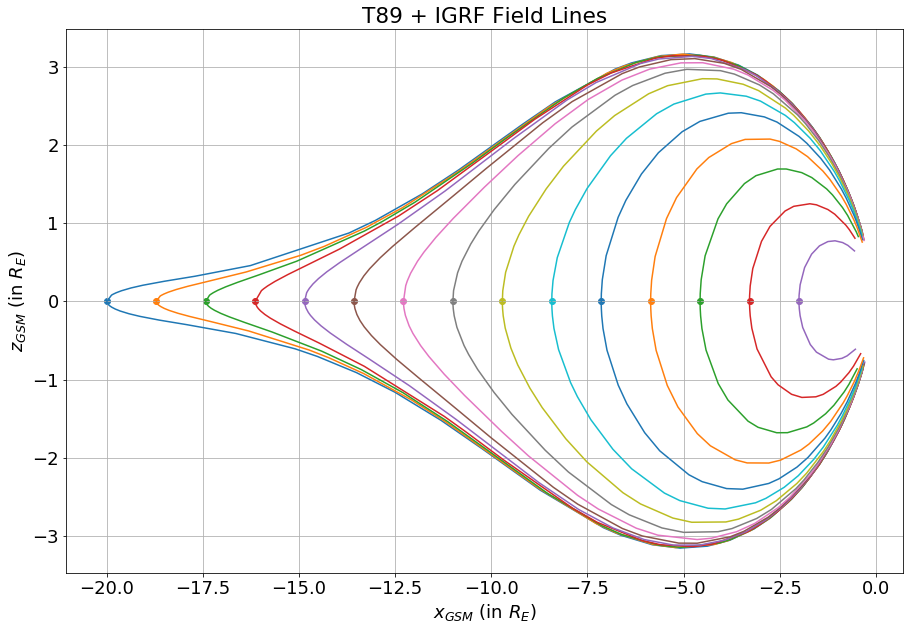

In [3]:
from field_utils import *

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 18})

for i, x in enumerate(np.linspace(-20 * Re, -2 * Re, 15)):
    rr = field_line(b_field, np.array([x, 0, 0]), 1e1)
    r_min = field_reversal(b_field, rr)
    
    plt.plot(rr[:, 0] / Re, rr[:, 2] / Re)
    plt.scatter(r_min[0] / Re, r_min[2] / Re)
    
plt.grid()
plt.xlabel('$x_{GSM}$ (in $R_E$)')
plt.ylabel('$z_{GSM}$ (in $R_E$)')
plt.title('T89 + IGRF Field Lines')
plt.show()

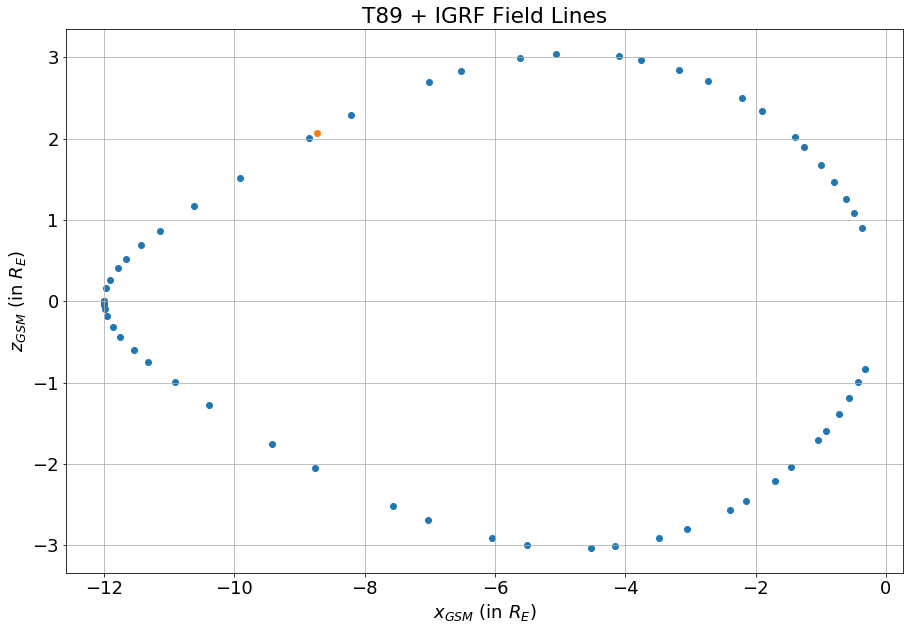

In [4]:
from field_utils import *

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 18})

rr = field_line(b_field, np.array([-12 * Re, 0, 0]), 1e1)
r_min = field_reversal(b_field, rr)
r, pa = param_by_eq_pa(b_field, rr, np.radians(20))

plt.scatter(rr[:, 0] / Re, rr[:, 2] / Re)
plt.scatter(r[0] / Re, r[2] / Re)

plt.grid()
plt.xlabel('$x_{GSM}$ (in $R_E$)')
plt.ylabel('$z_{GSM}$ (in $R_E$)')
plt.title('T89 + IGRF Field Lines')
plt.show()

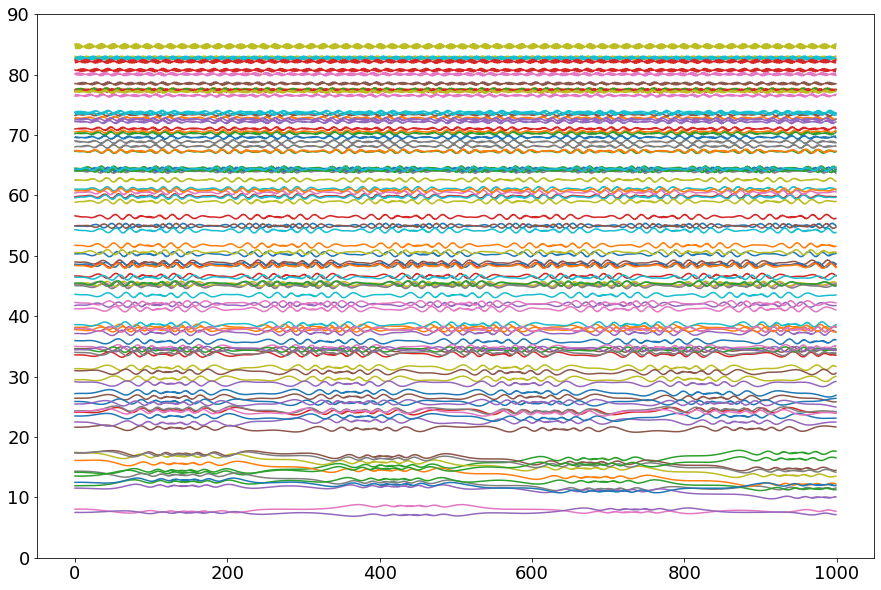

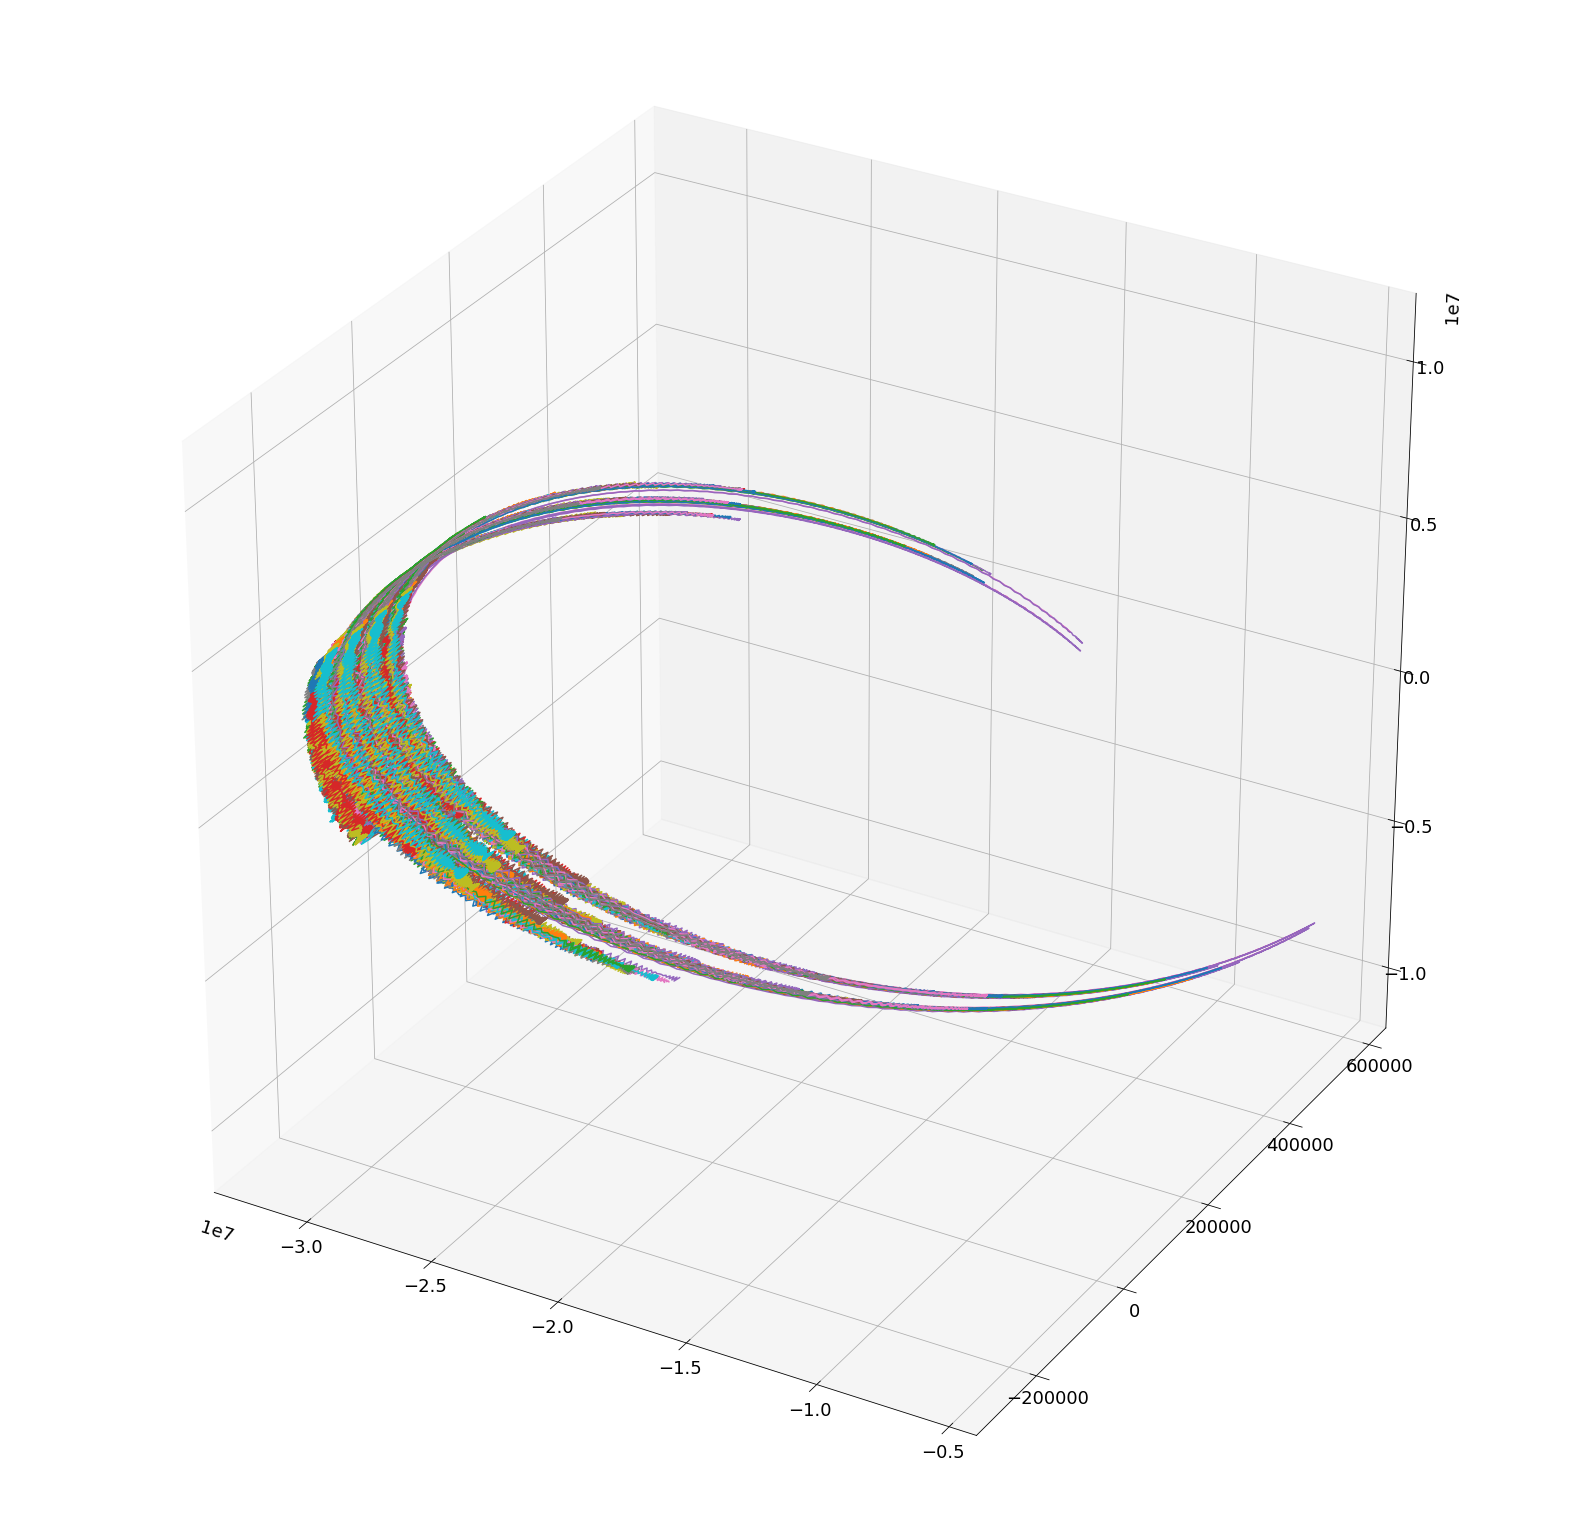

In [53]:
T      = 1          # Total time (in seconds)
dt     = 1e-3        # Simulation time step
trials = 100         # Number of runs
steps  = int(T / dt) # Number of steps per run

history, intrinsic = populate_by_eq_pa(trials,
                              steps,
                              e_field,
                              b_field,
                              delta(5),
                              delta(5e5),
                              uniform(np.radians(5), np.radians(85)),
                              uniform(0, 2 * np.pi)
                             )

solve(history, intrinsic, dt)

eqpas = eq_pitch_angle_from_moment(history, intrinsic)
plt.figure(figsize=(15, 10))
for i in range(trials):
    plt.plot(eqpas[i])

plt.ylim([0, 90])
plt.show()

plot_traj(history)

In [54]:
def get_eq_pas(history, intrinsic, dt, threshold=0.2, min_time=5e-3, padding=5e-3):
    eq_pa_hist = eq_pitch_angle_from_moment(history, intrinsic)
    
    all_eq_pas = np.zeros((len(history[:, 0, 0, 0]), len(history[0, :, 0, 0]), 3)) - 1
    
    for j in range(len(eq_pa_hist[:, 0])):
        centered = np.diff(eq_pa_hist[j, :], prepend=eq_pa_hist[j, 0])
        within_thresh = np.argwhere(np.abs(centered) <= threshold)[:, 0]

        contiguous = np.diff(within_thresh, prepend=within_thresh[0])

        endpoints = []

        pad = int(min_time / dt)
        stretch = int(padding / dt)

        endpoints = []
        endpoints_tentative = np.where(np.concatenate(([contiguous[0]], contiguous[:-1] != contiguous[1:], [1])))[0] - 1
        for i in range(int(len(endpoints_tentative) / 2)):
            if ((endpoints_tentative[2 * i + 1] - pad) - (endpoints_tentative[2 * i] + pad)) > stretch:
                endpoints.append(endpoints_tentative[2 * i] + pad)
                endpoints.append(endpoints_tentative[2 * i + 1] - pad)

        for i in range(int(len(endpoints) / 2)):
            all_eq_pas[j, i, 0] = np.mean(eq_pa_hist[j, :][within_thresh][endpoints[2 * i]:endpoints[2 * i + 1]])
            all_eq_pas[j, i, 1] = endpoints[2 * i]
            all_eq_pas[j, i, 2] = endpoints[2 * i + 1]
    
    k = 1
    for i in range(len(all_eq_pas[:, 0, 0])):
        j = 1
        while all_eq_pas[i, j - 1, 0] != -1:
            j += 1
        if j > k:
            k = j
        
    new_eq_pas = np.zeros((len(history[:, 0, 0, 0]), k, 3)) - 1
    new_eq_pas = all_eq_pas[:, 0:k, :]
        
    return new_eq_pas

In [55]:
alleqpas = get_eq_pas(history, intrinsic, dt)

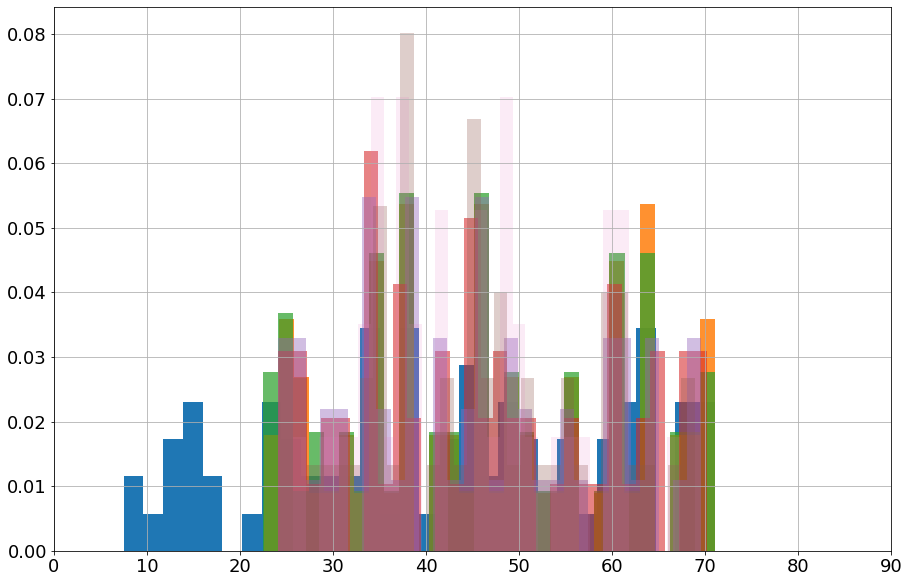

In [59]:
i = 7

plt.figure(figsize=(15, 10))

for j in range(i):
    indices = np.argwhere(alleqpas[:, j, 0] != -1.0)[:, 0]
    plt.hist(alleqpas[indices, j, 0], bins=30, histtype='stepfilled', density=True, alpha=(i - j)/i)
    
plt.xlim([0, 90])
plt.grid()
plt.show()

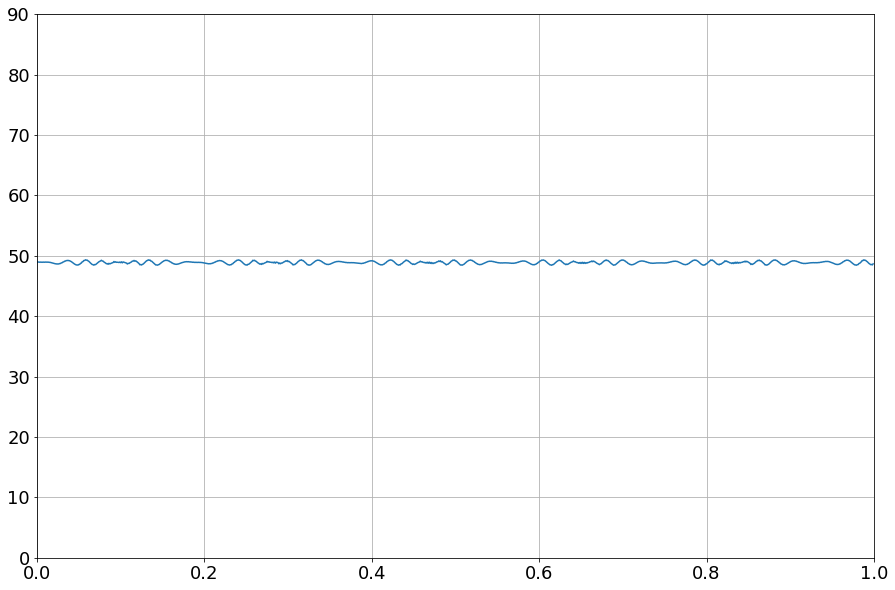

In [60]:
plt.figure(figsize=(15, 10))

i = 5
rms = eqpas[i]
centered = np.diff(rms, prepend=rms[0])
within_thresh = np.argwhere(np.abs(centered) <= 0.2)[:, 0]

plt.plot(within_thresh * dt, rms[within_thresh])

contiguous = np.diff(within_thresh, prepend=within_thresh[0])

endpoints = []

pad = 50
stretch = 50

endpoints = []
endpoints_tentative = np.where(np.concatenate(([contiguous[0]], contiguous[:-1] != contiguous[1:], [1])))[0] - 1
for i in range(int(len(endpoints_tentative) / 2)):
    if ((endpoints_tentative[2 * i + 1] - pad) - (endpoints_tentative[2 * i] + pad)) > stretch:
        endpoints.append(endpoints_tentative[2 * i] + pad)
        endpoints.append(endpoints_tentative[2 * i + 1] - pad)
        
for i in range(int(len(endpoints) / 2)):
    plt.hlines(np.mean(rms[within_thresh][endpoints[2 * i]:endpoints[2 * i + 1]]), within_thresh[endpoints[2 * i]] * dt, within_thresh[endpoints[2 * i + 1]] * dt, linestyle='-', linewidth=5)

plt.ylim([0, 90])
plt.xlim([0, 1])
plt.grid()
plt.show()